# Overview
The goal of the notebook is to to try and learn to register two chest -xray images by learning to match their lung segmentations (since this has a nicer loss function). The model thus tries to shift pixels around (Dense2DTranfomer) in order to make the lungs in the image overlap as much as possible
# Detals
## VoxelMorph2D for CXR Registration
VoxelMorph presents a nice idea of using a U-net for producing the offset field (rather than the typical use-case of segmentation). We apply this to registering patients X-ray scans since it is a nice fully deformable approach that works without any ground truth

In [1]:
import numpy as np # linear algebra
import tensorflow as tf # for tensorflow based registration
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.util import montage as montage2d
import os
from cv2 import imread, createCLAHE # read and equalize images
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
cxr_paths = glob(os.path.join('..', 'data', 'lung_segmentation', 'MontgomerySet', '*', '*.png'))
cxr_images = [(c_path, 
               [os.path.join('/'.join(c_path.split('/')[:-2]),'ManualMask','leftMask', os.path.basename(c_path)),
               os.path.join('/'.join(c_path.split('/')[:-2]),'ManualMask','rightMask', os.path.basename(c_path))]
              ) for c_path in cxr_paths]
print('CXR Images', len(cxr_paths), cxr_paths[0])
print(cxr_images[0])

CXR Images 138 ../data/lung_segmentation/MontgomerySet/CXR_png/MCUCXR_0113_1.png
('../data/lung_segmentation/MontgomerySet/CXR_png/MCUCXR_0113_1.png', ['../data/lung_segmentation/MontgomerySet/ManualMask/leftMask/MCUCXR_0113_1.png', '../data/lung_segmentation/MontgomerySet/ManualMask/rightMask/MCUCXR_0113_1.png'])


In [7]:
from skimage.io import imread as imread_raw
from skimage.transform import resize
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore', category=UserWarning, module='skimage') # skimage is really annoying
OUT_DIM = (512, 512)
def imread(in_path, apply_clahe = True):
    img_data = imread_raw(in_path)
    n_img = (255*resize(img_data, OUT_DIM, mode = 'constant')).clip(0,255).astype(np.uint8)
    if apply_clahe:
        clahe_tool = createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
        n_img = clahe_tool.apply(n_img)
    return np.expand_dims(n_img, -1)

In [ ]:
#img_vol, seg_vol = [], []
#for img_path, s_paths in tqdm(cxr_images):
#    img_vol += [imread(img_path)]    
#    seg_vol += [np.max(np.stack([imread(s_path, apply_clahe = False) for s_path in s_paths],0),0)]
#img_vol = np.stack(img_vol,0)
#seg_vol = np.stack(seg_vol,0)
#print('Images', img_vol.shape, 'Segmentations', seg_vol.shape)

In [4]:
#np.save('data.npy', [img_vol, seg_vol])
with open('data.npy', 'rb') as f:
    [a,b] = np.load(f)

img_vol = np.stack(a,0)
seg_vol = np.stack(b,0)
print('Images', img_vol.shape, 'Segmentations', seg_vol.shape)

Images (138, 512, 512, 1) Segmentations (138, 512, 512, 1)


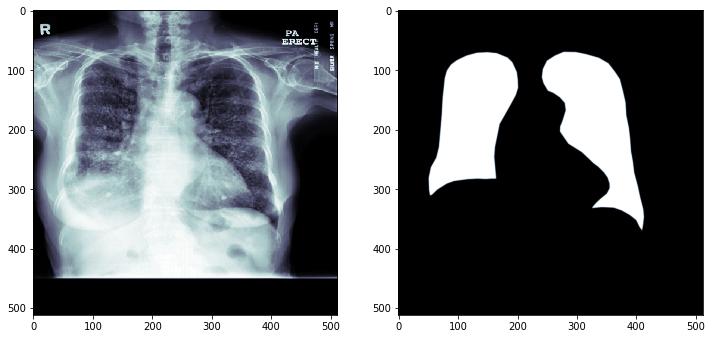

In [5]:
np.random.seed(2018)
t_img, m_img = img_vol[0], seg_vol[0]

fig, (ax_img, ax_mask) = plt.subplots(1,2, figsize = (12, 6))
ax_img.imshow(np.clip(255*t_img, 0, 255).astype(np.uint8) if t_img.shape[2]==3 else t_img[:,:,0],
              interpolation = 'none', cmap = 'bone')
ax_mask.imshow(m_img[:,:,0], cmap = 'bone')

# Make the Atlas Scan
Here is the master scan, against which we register everything else

Text(0.5, 1.0, 'Atlas Segmentation')

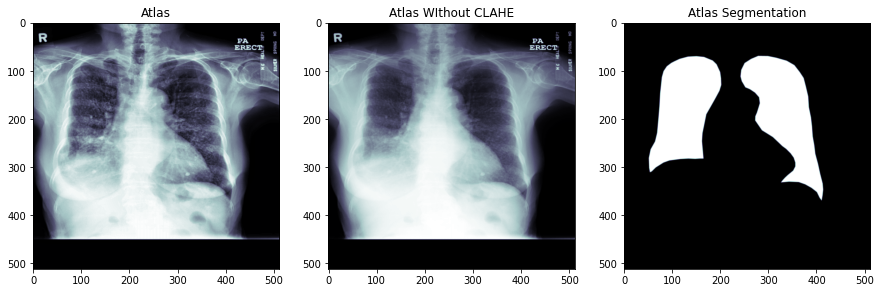

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
atlas_idx = 0
atlas_img = img_vol[atlas_idx:(atlas_idx+1)]
atlas_seg = seg_vol[atlas_idx:(atlas_idx+1)]
ax1.imshow(atlas_img[0, :, :, 0], cmap = 'bone')
ax1.set_title('Atlas')
no_clahe_img = imread(cxr_images[atlas_idx][0], apply_clahe = False)
ax2.imshow(no_clahe_img[:, :, 0], cmap = 'bone')
ax2.set_title('Atlas WIthout CLAHE')
ax3.imshow(atlas_seg[0, :, :, 0], cmap = 'bone')
ax3.set_title('Atlas Segmentation')

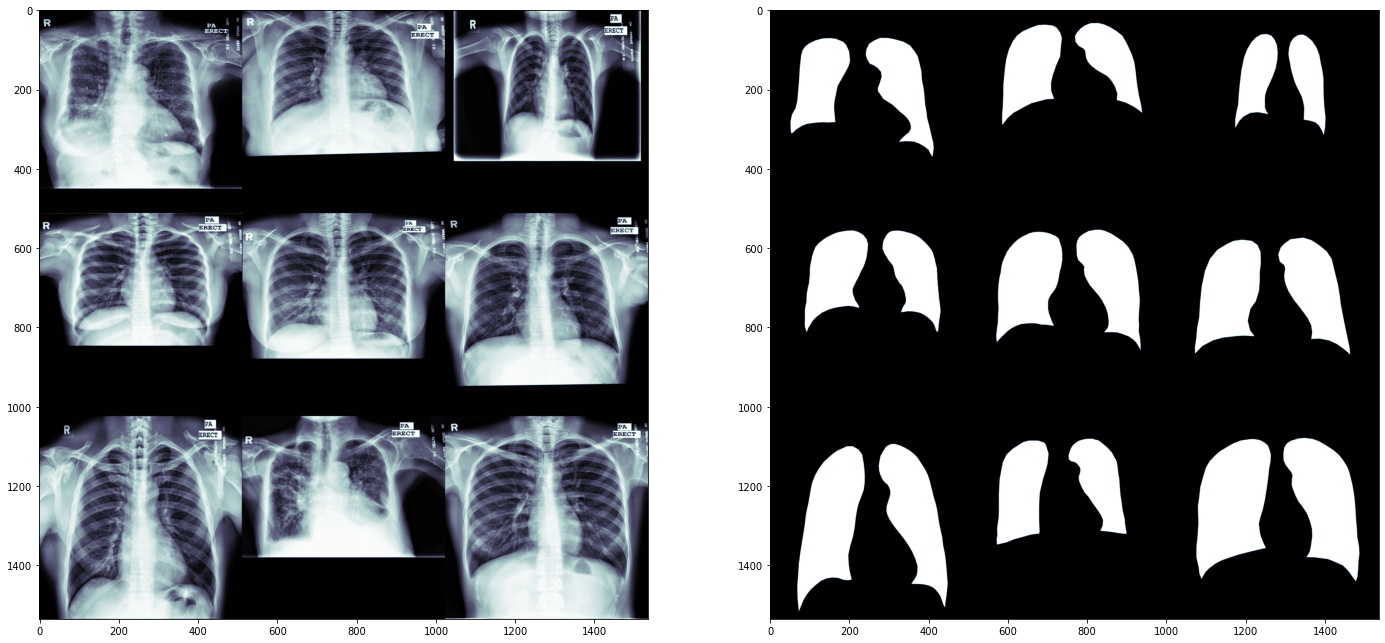

In [9]:
# might as well show-em if we have em
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,12))
ax1.imshow(montage2d(img_vol[:9, :, :, 0]), cmap = 'bone')
ax2.imshow(montage2d(seg_vol[:9, :, :, 0]), cmap = 'bone')
fig.savefig('overview.png', dpi = 300)

# Registration Problem
We would like to register the two images so we can focus on the differences. In the example below we try to subtract the two scans and the difference image has lots of structures from the original image visible not just the differences

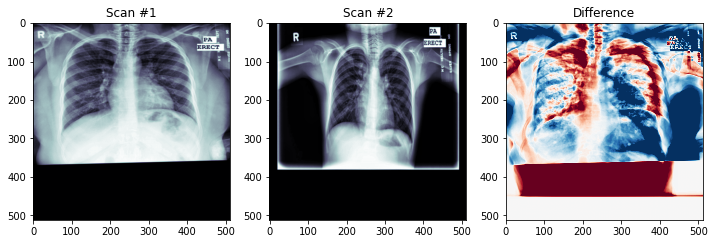

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))
ax1.imshow(img_vol[1, :, :, 0], cmap = 'bone', vmax = 255)
ax1.set_title('Scan #1')
ax2.imshow(img_vol[2, :, :, 0], cmap = 'bone', vmax = 255)
ax2.set_title('Scan #2')
ax3.imshow((1.0*img_vol[1]-img_vol[0])[:, :, 0], vmin = -100, vmax = 100, cmap = 'RdBu')
ax3.set_title('Difference');

# Create Dense Spatial Transformer
There are many affine and similar like approaches for transforming images but what we want here is a truly deformable model for every pixel so we have to implement it ourselves

In [11]:
from keras.layers.core import Layer
import tensorflow as tf
class Dense2DSpatialTransformer(Layer):
    """
    The layer takes an input image and an offset field and generates a transformed version of the image
    """

    def __init__(self, **kwargs):
        super(Dense2DSpatialTransformer, self).__init__(**kwargs)

    def build(self, input_shape):
        if len(input_shape) > 3:
            raise Exception('Spatial Transformer must be called on a list of length 2 or 3. '
                            'First argument is the image, second is the offset field.')

        if len(input_shape[1]) != 4 or input_shape[1][3] != 2:
            raise Exception('Offset field must be one 4D tensor with 2 channels. '
                            'Got: ' + str(input_shape[1]))

        self.built = True

    def call(self, inputs):
        return self._transform(inputs[0], inputs[1][:, :, :, 0],
                               inputs[1][:, :, :, 1])

    def compute_output_shape(self, input_shape):
        return input_shape[0]

    def _transform(self, I, dx, dy):

        batch_size = tf.shape(dx)[0]
        height = tf.shape(dx)[1]
        width = tf.shape(dx)[2]

        # Convert dx and dy to absolute locations
        x_mesh, y_mesh = self._meshgrid(height, width)
        x_mesh = tf.expand_dims(x_mesh, 0)
        y_mesh = tf.expand_dims(y_mesh, 0)

        x_mesh = tf.tile(x_mesh, [batch_size, 1, 1])
        y_mesh = tf.tile(y_mesh, [batch_size, 1, 1])
        x_new = dx + x_mesh
        y_new = dy + y_mesh

        return self._interpolate(I, x_new, y_new)

    def _repeat(self, x, n_repeats):
        rep = tf.transpose(
            tf.expand_dims(tf.ones(shape=tf.stack([n_repeats, ])), 1), [1, 0])
        rep = tf.cast(rep, dtype='int32')
        x = tf.matmul(tf.reshape(x, (-1, 1)), rep)
        return tf.reshape(x, [-1])

    def _meshgrid(self, height, width):
        x_t = tf.matmul(tf.ones(shape=tf.stack([height, 1])),
                        tf.transpose(tf.expand_dims(tf.linspace(0.0,
                                                                tf.cast(width, tf.float32)-1.0, width), 1), [1, 0]))
        y_t = tf.matmul(tf.expand_dims(tf.linspace(0.0,
                                                   tf.cast(height, tf.float32)-1.0, height), 1),
                        tf.ones(shape=tf.stack([1, width])))

        return x_t, y_t

    def _interpolate(self, im, x, y):

        im = tf.pad(im, [[0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT")

        num_batch = tf.shape(im)[0]
        height = tf.shape(im)[1]
        width = tf.shape(im)[2]
        channels = tf.shape(im)[3]

        out_height = tf.shape(x)[1]
        out_width = tf.shape(x)[2]

        x = tf.reshape(x, [-1])
        y = tf.reshape(y, [-1])

        x = tf.cast(x, 'float32')+1
        y = tf.cast(y, 'float32')+1

        max_x = tf.cast(width - 1, 'int32')
        max_y = tf.cast(height - 1, 'int32')

        x0 = tf.cast(tf.floor(x), 'int32')
        x1 = x0 + 1
        y0 = tf.cast(tf.floor(y), 'int32')
        y1 = y0 + 1

        x0 = tf.clip_by_value(x0, 0, max_x)
        x1 = tf.clip_by_value(x1, 0, max_x)
        y0 = tf.clip_by_value(y0, 0, max_y)
        y1 = tf.clip_by_value(y1, 0, max_y)
        
        dim3 = 1
        dim2 = width
        dim1 = width*height
        base = self._repeat(tf.range(num_batch)*dim1,
                            out_height*out_width)

        base_y0 = base + y0*dim2
        base_y1 = base + y1*dim2

        idx_a = base_y0 + x0*dim3 
        idx_b = base_y1 + x0*dim3
        idx_c = base_y0 + x1*dim3
        idx_d = base_y1 + x1*dim3
        idx_e = base_y0 + x0*dim3
        idx_f = base_y1 + x0*dim3
        idx_g = base_y0 + x1*dim3
        idx_h = base_y1 + x1*dim3

        # use indices to lookup pixels in the flat image and restore
        # channels dim
        im_flat = tf.reshape(im, tf.stack([-1, channels]))
        im_flat = tf.cast(im_flat, 'float32')

        Ia = tf.gather(im_flat, idx_a)
        Ib = tf.gather(im_flat, idx_b)
        Ic = tf.gather(im_flat, idx_c)
        Id = tf.gather(im_flat, idx_d)
        Ie = tf.gather(im_flat, idx_e)
        If = tf.gather(im_flat, idx_f)
        Ig = tf.gather(im_flat, idx_g)
        Ih = tf.gather(im_flat, idx_h)

        # and finally calculate interpolated values
        x1_f = tf.cast(x1, 'float32')
        y1_f = tf.cast(y1, 'float32')

        dx = x1_f - x
        dy = y1_f - y

        wa = tf.expand_dims((dx * dy), 1)
        wb = tf.expand_dims((dx * (1-dy)), 1)
        wc = tf.expand_dims(((1-dx) * dy), 1)
        wd = tf.expand_dims(((1-dx) * (1-dy)), 1)
        we = tf.expand_dims((dx * dy), 1)
        wf = tf.expand_dims((dx * (1-dy)), 1)
        wg = tf.expand_dims(((1-dx) * dy), 1)
        wh = tf.expand_dims(((1-dx) * (1-dy)), 1)

        output = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id,
                           we*Ie, wf*If, wg*Ig, wh*Ih])
        output = tf.reshape(output, tf.stack(
            [-1, out_height, out_width, channels]))
        return output

Using TensorFlow backend.


In [12]:
from keras.models import Model
from keras.layers import Input
t_image = Input((None, None, 1), name = 'InputImage')
t_offset = Input((None, None, 2), name = 'OffsetField')
t_out = Dense2DSpatialTransformer()([t_image, t_offset])
d2model = Model(inputs = [t_image, t_offset], outputs = [t_out])

# Using Test Patterns
We can use a test pattern to make sure the mess of a spatial transformer actually does what we think it is supposed to. We try two different basical things, one is shifting the top half different from the bottom half and the second is random noise.

In [13]:
def get_test_pattern(ref_img, scale = 10):
    xx, yy = np.meshgrid(range(ref_img.shape[0]), range(ref_img.shape[1]))
    mod_f = scale*4
    cut_f = scale*3
    return (((xx % mod_f)>cut_f)|((yy % mod_f)>cut_f)).astype(np.float32)
def show_st(in_x, in_off):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 6))
    ax1.imshow(in_x[0, :, :, 0], cmap = 'bone_r')
    ax1.set_title('Test Pattern')
    ax2.quiver(in_off[0, :, :, 0],
               in_off[0, :, :, 1]
              )
    cur_y = d2model.predict([in_x, in_off])
    ax3.imshow(cur_y[0, :, :, 0], cmap = 'bone_r')
    ax3.set_title('Transformed Pattern')

In [14]:
test_pattern = get_test_pattern(np.zeros((32, 32)), scale = 2)
test_x = np.expand_dims(np.expand_dims(test_pattern, 0), -1)
test_offset = np.zeros_like(np.concatenate([test_x, test_x], -1))
test_y = d2model.predict([test_x, test_offset])
print(test_x.shape, test_offset.shape, test_y.shape)

(1, 32, 32, 1) (1, 32, 32, 2) (1, 32, 32, 1)


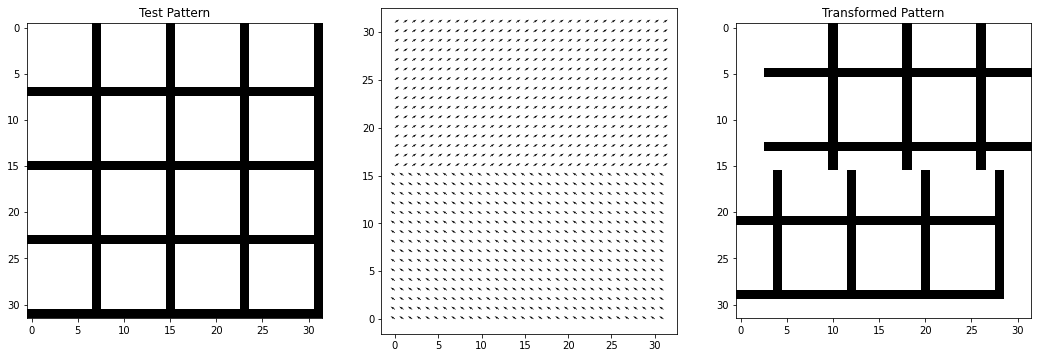

In [15]:
n_offset = test_offset.copy()
n_offset[0, :, :, 1] = 2
n_offset[0, :, :, 0] = -3
n_offset[0, n_offset.shape[1]//2:, :, 0]  = 3
show_st(test_x, n_offset)

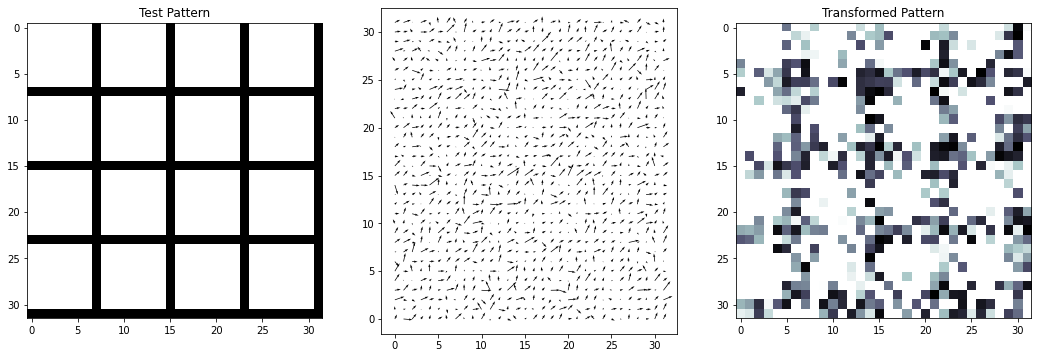

In [16]:
show_st(test_x, np.random.normal(1, 1, size = test_offset.shape))

# Make a Simple Model
Here we make a simple U-Net to create the offset field

In [17]:
from keras.layers import Conv2D, Activation, Input, UpSampling2D, concatenate, BatchNormalization
from keras.layers import LeakyReLU
from keras.initializers import RandomNormal
def c2(x_in, nf, strides=1):
    x_out = Conv2D(nf, kernel_size=3, padding='same',
                   kernel_initializer='he_normal', strides=strides)(x_in)
    x_out = LeakyReLU(0.2)(x_out)
    return x_out
def unet_enc(vol_size, enc_nf, pre_filter = 8):
    src = Input(shape=vol_size + (1,), name = 'EncoderInput')
    # down-sample path.
    x_in = BatchNormalization(name = 'NormalizeInput')(src)
    x_in = c2(x_in, pre_filter, 1)
    x0 = c2(x_in, enc_nf[0], 2)  
    x1 = c2(x0, enc_nf[1], 2)  
    x2 = c2(x1, enc_nf[2], 2)  
    x3 = c2(x2, enc_nf[3], 2) 
    return Model(inputs = [src], 
                outputs = [x_in, x0, x1, x2, x3],
                name = 'UnetEncoder')

In [18]:
def unet(vol_size, enc_nf, dec_nf, full_size=True):
    """
    unet network for voxelmorph 
    Args:
        vol_size: volume size. e.g. (256, 256, 256)
        enc_nf: encoder filters. right now it needs to be to 1x4.
            e.g. [16,32,32,32]
            TODO: make this flexible.
        dec_nf: encoder filters. right now it's forced to be 1x7.
            e.g. [32,32,32,32,8,8,3]
            TODO: make this flexible.
        full_size
    """

    # inputs
    src = Input(shape=vol_size + (1,), name = 'ImageInput')
    src_seg = Input(shape=vol_size + (1,), name = 'SegmentationInput')
    
    tgt = Input(shape=vol_size + (1,), name = 'AtlasInput')
    
    enc_model = unet_enc(vol_size, enc_nf)
    # run the same encoder on the source and the target and concatenate the output at each level
    x_in, x0, x1, x2, x3 = [concatenate([s_enc, t_enc]) 
                              for s_enc, t_enc in zip(enc_model(src), 
                                                      enc_model(tgt))]

    x = c2(x3, dec_nf[0])
    x = UpSampling2D()(x)
    x = concatenate([x, x2])
    x = c2(x, dec_nf[1])
    x = UpSampling2D()(x)
    x = concatenate([x, x1])
    x = c2(x, dec_nf[2])
    x = UpSampling2D()(x)
    x = concatenate([x, x0])
    x = c2(x, dec_nf[3])
    x = c2(x, dec_nf[4])
    x = UpSampling2D()(x)
    x = concatenate([x, x_in])
    x = c2(x, dec_nf[5])

    # transform the results into a flow.
    flow = Conv2D(dec_nf[-1], kernel_size=3, padding='same',
                  kernel_initializer=RandomNormal(mean=0.0, stddev=1e-5), name='flow')(x)

    # warp the source with the flow
    y_seg = Dense2DSpatialTransformer(name = 'dense_spatial')([src_seg, flow])

    # prepare model
    model = Model(inputs=[src, src_seg, tgt], outputs=[y_seg, flow])
    return model

In [20]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 
print(tf.__version__)

from tensorflow import test
test.is_gpu_available()

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0', '/device:GPU:0']
2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [21]:
# use the predefined depths
nf_enc=[16,32,32,32]
nf_dec=[32,32,32,32,32,16,16,2]
with tf.device('/device:CPU:0'):
    net = unet(OUT_DIM, nf_enc, nf_dec)
    # ensure the model roughly works
    a, b = net.predict([np.zeros((1,)+OUT_DIM+(1,)), 
                        np.zeros((1,)+OUT_DIM+(1,)),
                        np.zeros((1,)+OUT_DIM+(1,))])
    print(a.shape, b.shape)
    net.summary()

(1, 512, 512, 1) (1, 512, 512, 2)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageInput (InputLayer)         (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
AtlasInput (InputLayer)         (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
UnetEncoder (Model)             [(None, 512, 512, 8) 24388       ImageInput[0][0]                 
                                                                 AtlasInput[0][0]                 
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 32, 32, 64)   0    

In [22]:
from keras.losses import mean_squared_error

def gradientLoss(penalty='l1'):
    def loss(y_true, y_pred):
        dy = tf.abs(y_pred[:, 1:, :, :] - y_pred[:, :-1, :, :])
        dx = tf.abs(y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :])

        if (penalty == 'l2'):
            dy = dy * dy
            dx = dx * dx
        d = tf.reduce_mean(dx)+tf.reduce_mean(dy)
        return d/2.0

    return loss
def mean_squared_error_cropped(y_true, y_pred):
    crop_size = 20
    return mean_squared_error(y_true[:, crop_size: -crop_size, crop_size:-crop_size, :],
                             y_pred[:, crop_size:-crop_size, crop_size:-crop_size, :])

In [23]:
from keras.optimizers import Adam
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

reg_param = 1.0
lr = 1e-3
dice_bce_param = 0.3
use_dice = True

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return dice_bce_param*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

net.compile(optimizer=Adam(lr=lr), 
              loss=[dice_p_bce if use_dice else mean_squared_error_cropped, gradientLoss('l2')], 
              loss_weights=[1.0, reg_param])

# Create Training Data Generator
Here we make a tool to generate training data from the X-ray scans

Train (110, 512, 512, 1) Test (28, 512, 512, 1) -0.0797866375025266 1.0078740157480315
Seg (110, 512, 512, 1) 1.0 [0. 1.]


(array([21336586.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,  7499254.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

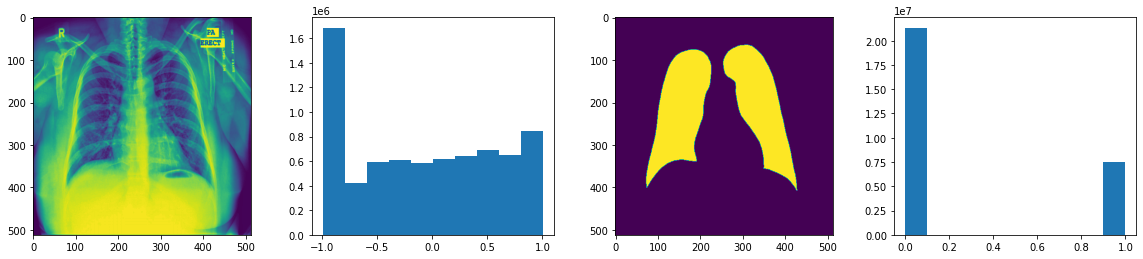

In [25]:
from sklearn.model_selection import train_test_split
train_vol, test_vol, train_seg, test_seg = train_test_split((img_vol-127.0)/127.0, 
                                                            (seg_vol>127).astype(np.float32), 
                                                            test_size = 0.2, 
                                                            random_state = 2018)
print('Train', train_vol.shape, 'Test', test_vol.shape, test_vol.mean(), test_vol.max())
print('Seg', train_seg.shape, train_seg.max(), np.unique(train_seg.ravel()))
fig, (ax1, ax1hist, ax2, ax2hist) = plt.subplots(1, 4, figsize = (20, 4))
ax1.imshow(test_vol[0, :, :, 0])
ax1hist.hist(test_vol.ravel())
ax2.imshow(test_seg[0, :, :, 0]>0.5)
ax2hist.hist(train_seg.ravel())

In [26]:
atlas_idx = 0
atlas_img = train_vol[atlas_idx]
atlas_seg = train_seg[atlas_idx]
def gen_batched_pairs(in_vol, in_seg, batch_size = 16):
    moving_img = []
    moving_seg = []
    fixed_img = []
    fixed_seg = []
    while True:
        #[X, atlas_vol], [atlas_vol, zero_flow]
        idx_list = np.random.permutation(range(in_vol.shape[0]))
        for c_idx in idx_list:
            
            moving_img += [in_vol[c_idx]]
            moving_seg += [in_seg[c_idx]]
            fixed_img += [atlas_img]
            fixed_seg += [atlas_seg]
            
            if len(moving_img)==batch_size:
                moving_img = np.stack(moving_img, 0)
                moving_seg = np.stack(moving_seg, 0)
                fixed_img = np.stack(fixed_img, 0)
                fixed_seg = np.stack(fixed_seg, 0)
                
                zero_flow = np.zeros(moving_img.shape[:3]+(2,))
                
                yield [moving_img, moving_seg, fixed_img], [fixed_seg, zero_flow]
                moving_img = []
                moving_seg = []
                fixed_img = []
                fixed_seg = []
                
def hard_code_pairs(in_gen, count):
    """freeze the values in a generator"""
    full_list = [x for x, _ in zip(in_gen, range(count))]
    print('saved...', len(full_list))
    while True:
        for x in full_list:
            yield x

## Adding Augmentation
Here we use augmentation to get more data into the model

In [27]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 5, 
                  width_shift_range = 0.05, 
                  height_shift_range = 0.05, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.1],  
                  horizontal_flip = False, 
                  vertical_flip = False,
                  fill_mode = 'nearest',
               data_format = 'channels_last')

image_gen = ImageDataGenerator(**dg_args)

def gen_augmented_pairs(in_vol, in_seg, batch_size = 16):
    while True:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_vol = image_gen.flow(in_vol, batch_size = batch_size, seed = seed)
        g_seg = image_gen.flow(in_seg, batch_size = batch_size, seed = seed)
        for i_vol, i_seg in zip(g_vol, g_seg):
            fixed_img = np.stack(i_vol.shape[0]*[atlas_img], 0)
            fixed_seg = np.stack(i_vol.shape[0]*[atlas_seg], 0)
            
            zero_flow = np.zeros(i_vol.shape[:3]+(2,))
            yield [i_vol, i_seg, fixed_img], [fixed_seg, zero_flow]

In [28]:
train_gen = gen_augmented_pairs(train_vol[1:], train_seg[1:], batch_size = 16)
test_gen = hard_code_pairs(gen_batched_pairs(test_vol, test_seg), 2*len(test_vol))
[train_X, train_Xseg, train_Y], _ = next(train_gen)
[test_X, test_Xseg, test_Y], [out_x, out_y] = next(test_gen)
print(test_X.shape, test_Y.shape, out_x.shape, out_y.shape)

saved... 56
(16, 512, 512, 1) (16, 512, 512, 1) (16, 512, 512, 1) (16, 512, 512, 2)


### Training Data

Text(0.5, 1.0, 'Atlas Image')

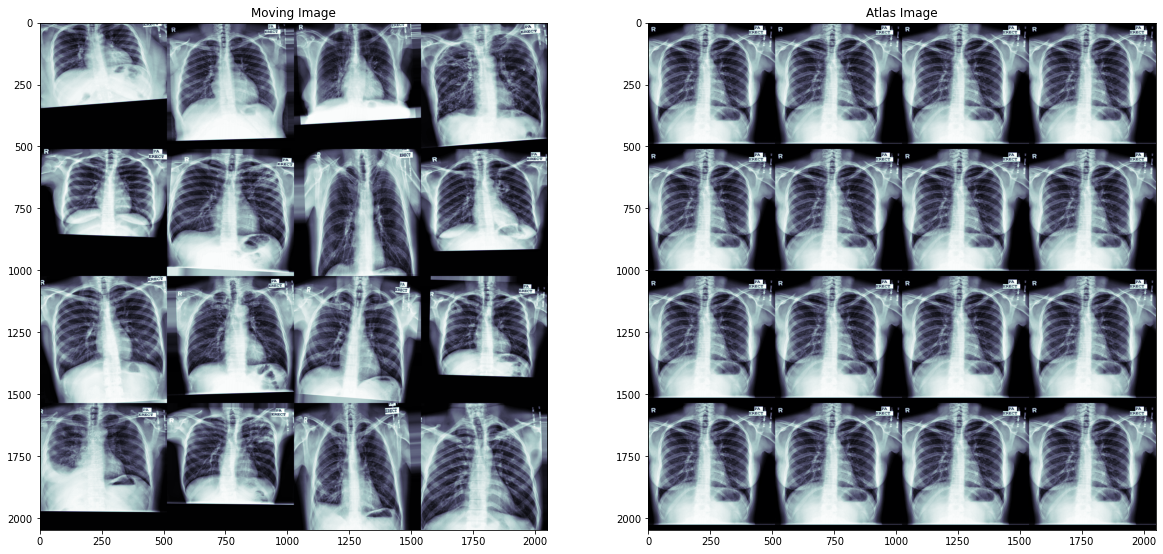

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage2d(train_X[:, :, :, 0]), cmap = 'bone')
ax1.set_title('Moving Image')
ax2.imshow(montage2d(train_Y[:, :, :, 0]), cmap = 'bone')
ax2.set_title('Atlas Image')

### Validation Date

Text(0.5, 1.0, 'Atlas Image')

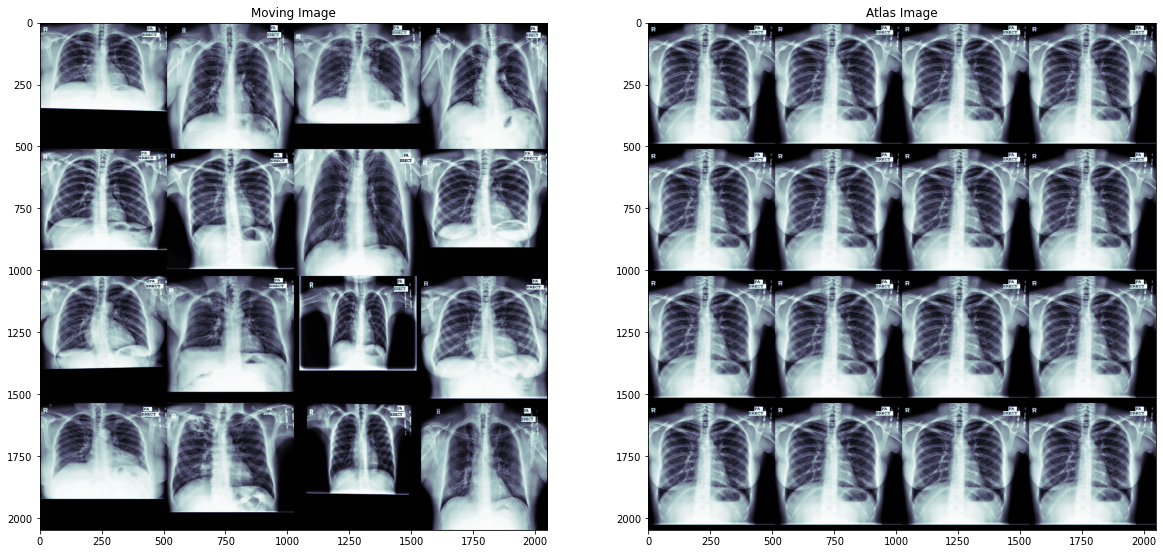

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage2d(test_X[:, :, :, 0]), cmap = 'bone')
ax1.set_title('Moving Image')
ax2.imshow(montage2d(test_Y[:, :, :, 0]), cmap = 'bone')
ax2.set_title('Atlas Image')

## Show Untrained Results
Here we show random untrained results

/home/nttputus/py-env/pip/virto/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


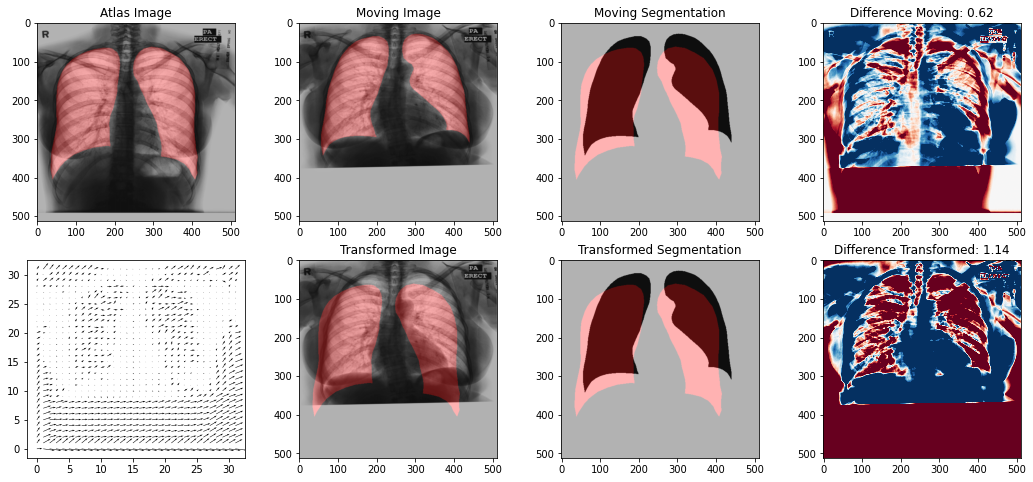

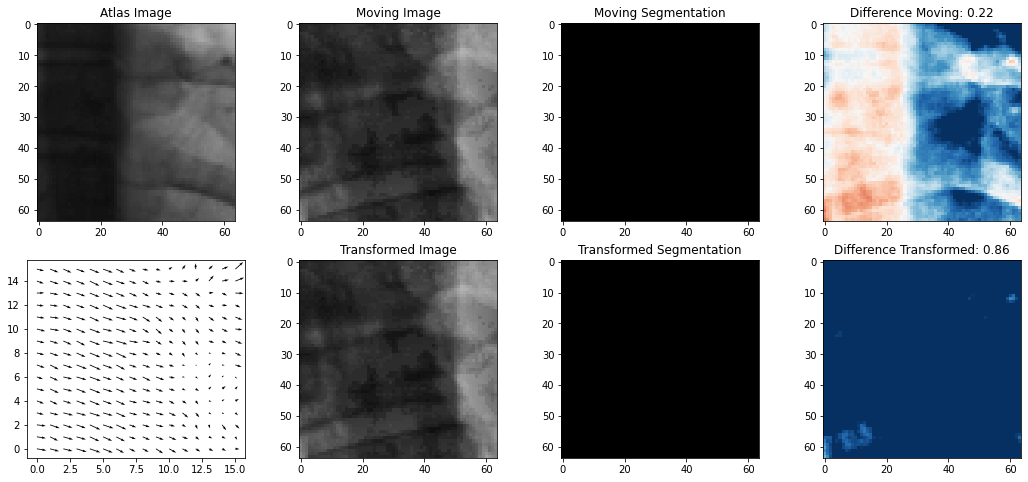

In [32]:
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb
def add_boundary(in_img, in_seg, cmap = 'bone', norm = True, add_labels = True):
    if norm:
        n_img = (1.0*in_img-in_img.min())/(1.1*(in_img.max()-in_img.min()))
    else:
        n_img = in_img
    rgb_img = plt.cm.get_cmap(cmap)(n_img)[:, :, :3]
    if add_labels:
        return label2rgb(image = rgb_img, label = in_seg.astype(int), bg_label = 0)
    else:
        return mark_boundaries(image = rgb_img, label_img = in_seg.astype(int), color = (0, 1, 0), mode = 'thick')
def show_full_st(in_x, in_seg, in_off, in_y, y_seg, ds_quiver = 16):
    dfkw = dict(vmin = -.5, vmax = 0.5, cmap = 'RdBu')
    fig, [(ax_gt, ax1, ax1seg, ax_dif), (ax2, ax3, ax3seg, ax4)] = plt.subplots(2, 4, figsize = (18, 8))
    ax1.imshow(add_boundary(in_x[0, :, :, 0], in_seg[0, :, :, 0]*2, cmap = 'bone_r'))
    ax1.set_title('Moving Image')
    
    ax1seg.imshow(add_boundary(in_seg[0, :, :, 0], y_seg[0, :, :, 0], cmap = 'bone_r'))
    ax1seg.set_title('Moving Segmentation')
    
    ax_gt.imshow(add_boundary(in_y[0, :, :, 0], y_seg[0, :, :, 0], cmap = 'bone_r'))
    ax_gt.set_title('Atlas Image')
    
    ax_dif.imshow(in_x[0, :, :, 0]-in_y[0, :, :, 0], **dfkw)
    mae = np.mean(np.abs(in_x[0, :, :, 0]-in_y[0, :, :, 0]))
    ax_dif.set_title('Difference Moving: %2.2f' % (mae))
    
    ax2.quiver(in_off[0, ::-ds_quiver, ::ds_quiver, 0],
               in_off[0, ::-ds_quiver, ::ds_quiver, 1]
              )
    
    cur_x = d2model.predict([in_x, in_off])
    ax3.imshow(add_boundary(cur_x[0, :, :, 0], y_seg[0, :, :, 0], cmap = 'bone_r'))
    ax3.set_title('Transformed Image')
    
    cur_x_seg = d2model.predict([in_seg, in_off])
    ax3seg.imshow(add_boundary(cur_x_seg[0, :, :, 0], y_seg[0, :, :, 0], cmap = 'bone_r'))
    ax3seg.set_title('Transformed Segmentation')
    
    ax4.imshow(cur_x[0, :, :, 0]-in_y[0, :, :, 0], **dfkw)
    mae = np.mean(np.abs(cur_x[0, :, :, 0]-in_y[0, :, :, 0]))
    ax4.set_title('Difference Transformed: %2.2f' % (mae))
def show_examples(n=1, with_roi = True):
    roi_func = lambda x: x[:, 
                               OUT_DIM[0]//2-32:OUT_DIM[0]//2+32,
                               OUT_DIM[1]//2-32:OUT_DIM[1]//2+32,
                               :
                              ]
    for ([test_X, test_Xseg, test_Y], [seg_Y, _]), _ in zip(test_gen, range(n)):
        
        with tf.device('/device:CPU:0'):
            m_img, flow = net.predict([test_X, test_Xseg, test_Y])
        show_full_st(test_X, test_Xseg, flow, test_Y, seg_Y)
        show_full_st(roi_func(test_X), roi_func(test_Xseg), roi_func(flow), roi_func(test_Y), roi_func(seg_Y), ds_quiver = 4)

show_examples(1)

In [33]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/home/nttputus/py-env/pip/virto/lib/python3.6/site-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [36]:
from IPython.display import clear_output

with tf.device('/device:CPU:0'):
    loss_history = net.fit_generator(train_gen, 
                      steps_per_epoch=len(train_vol)//train_X.shape[0],
                      epochs = 10,
                      validation_data = test_gen,
                      validation_steps = 2*len(test_vol),
                      callbacks=callbacks_list
                     )

In [37]:
net.load_weights(weight_path)
net.save('full_model.h5')

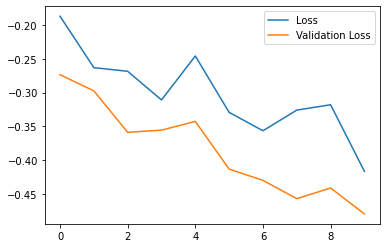

In [38]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

# Test some Images

/home/nttputus/py-env/pip/virto/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


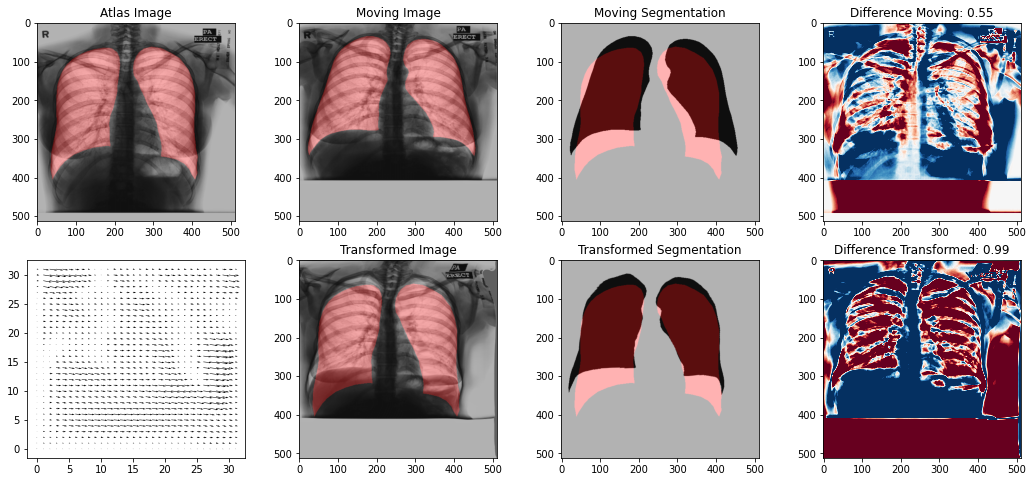

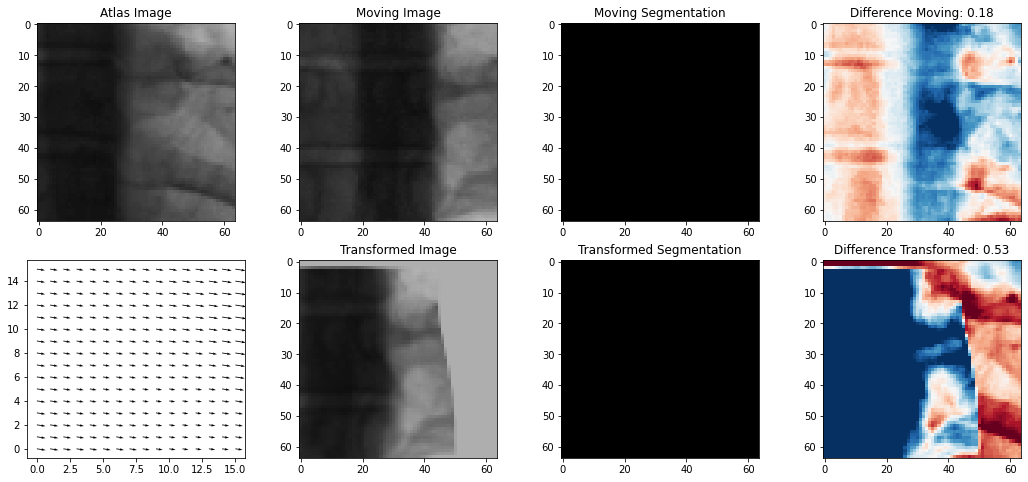

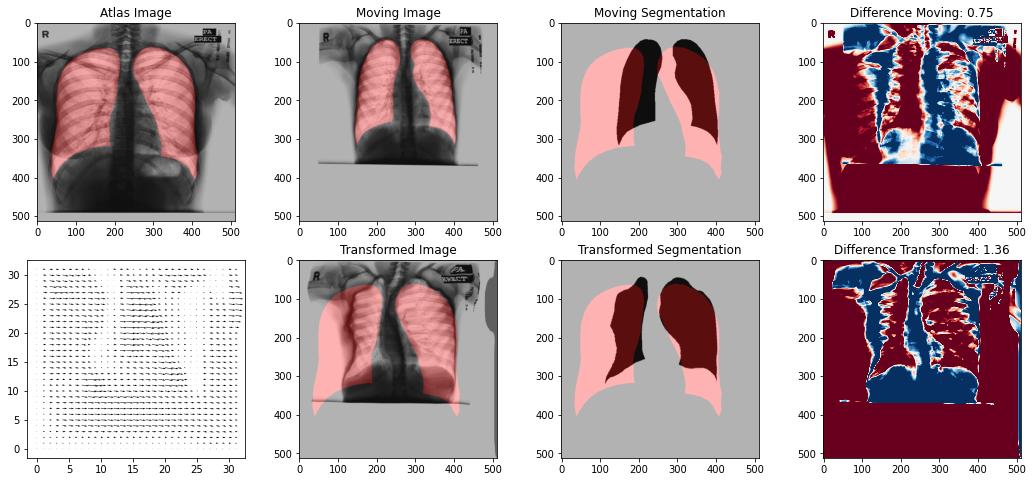

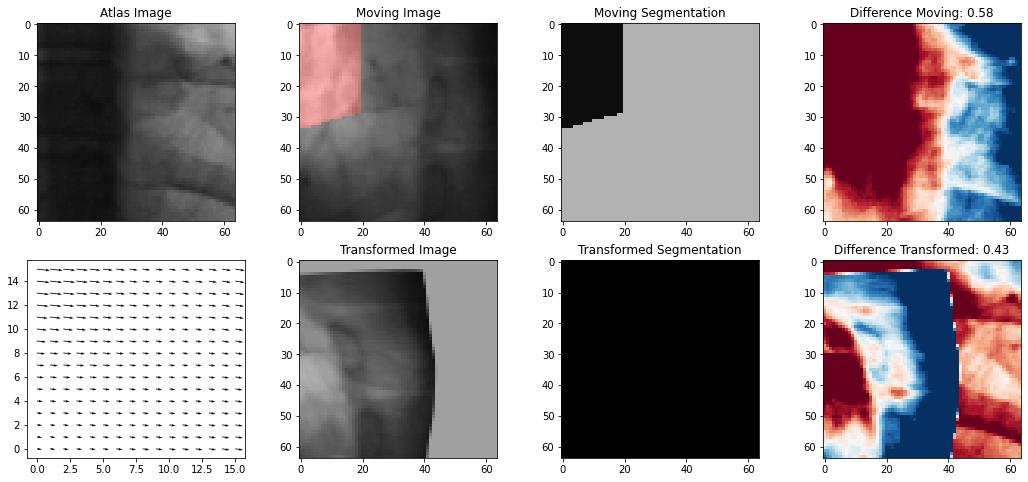

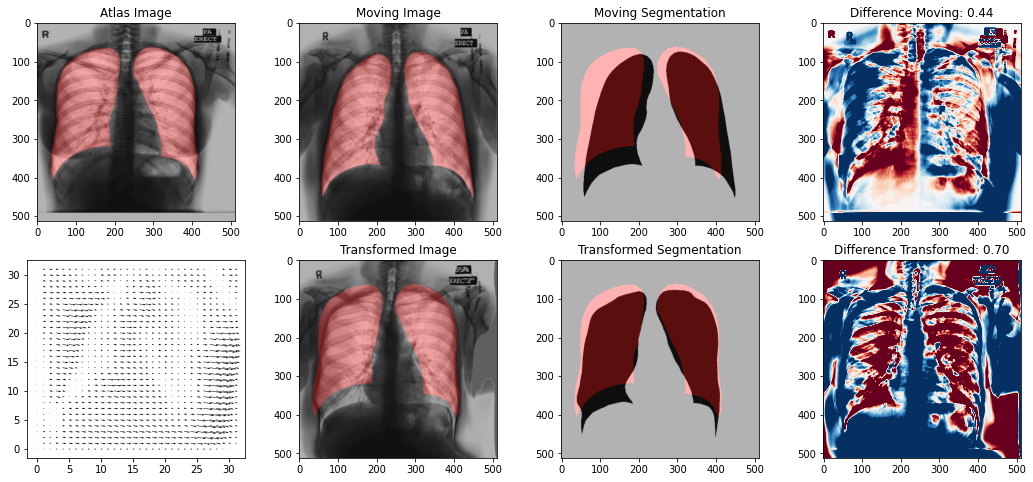

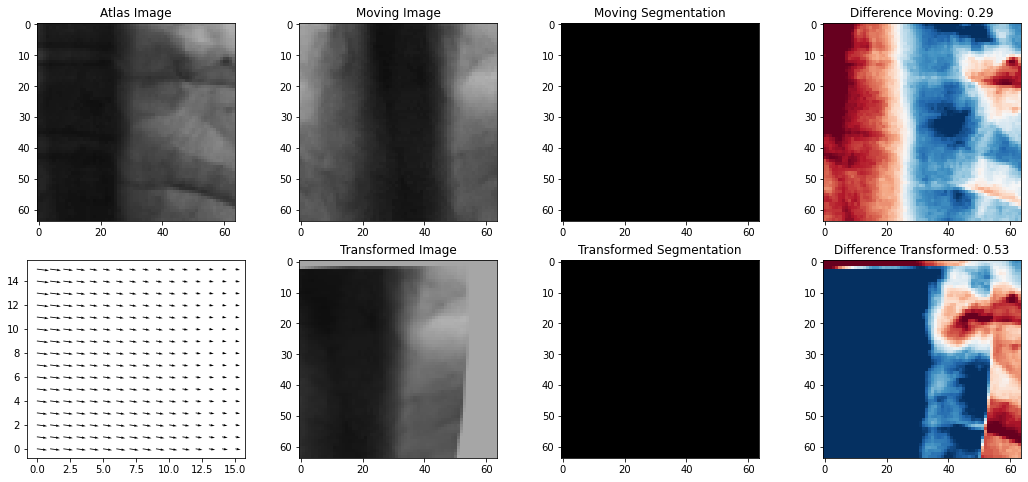

In [39]:
show_examples(3)

/home/nttputus/py-env/pip/virto/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


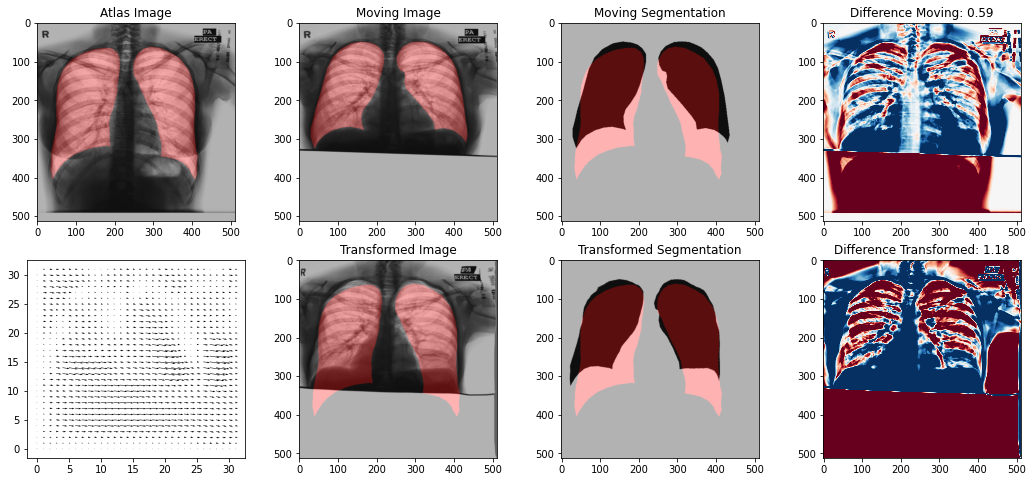

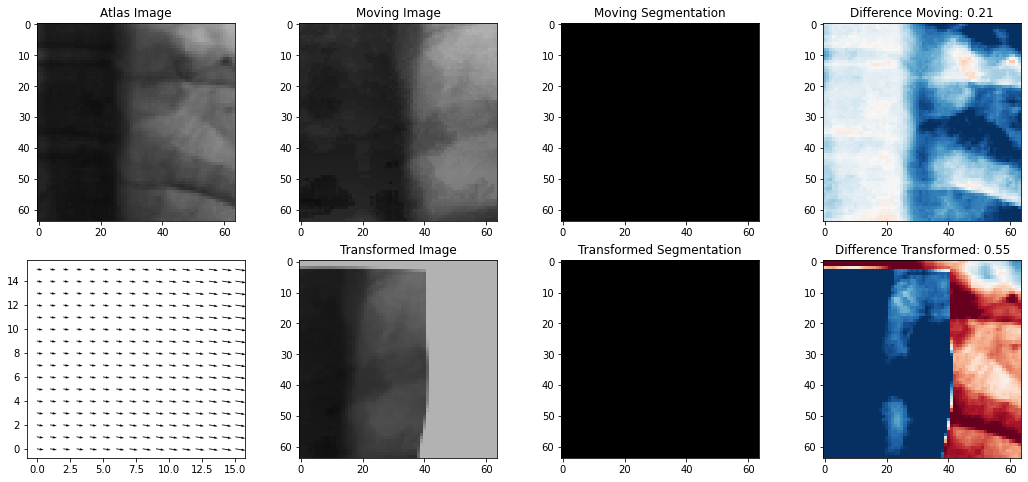

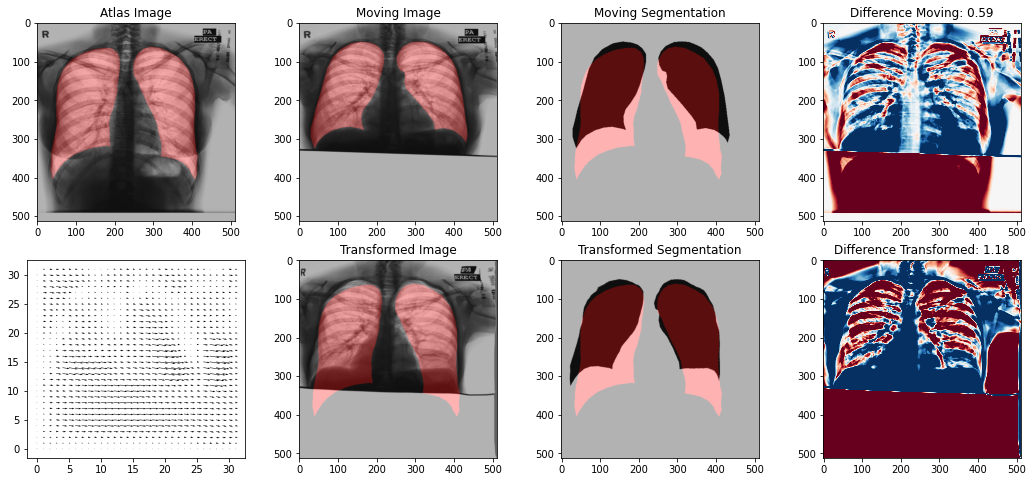

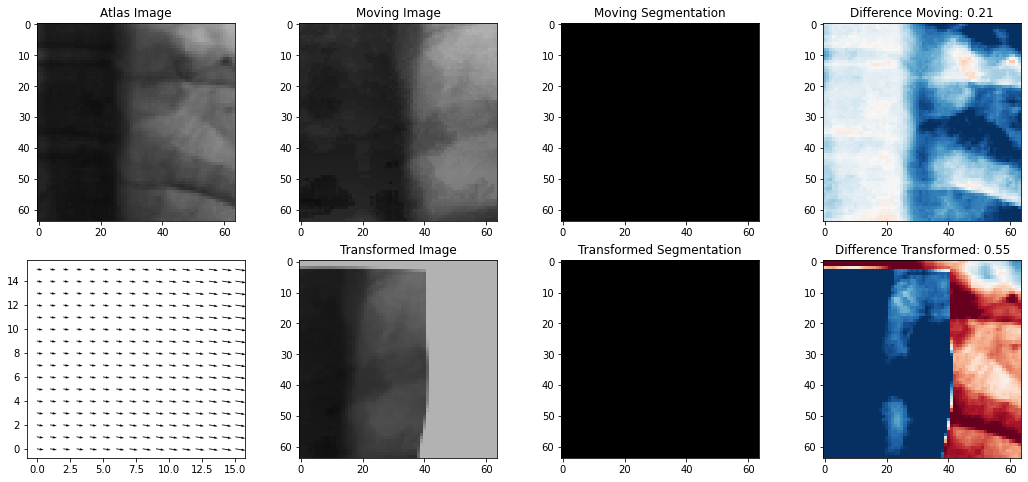

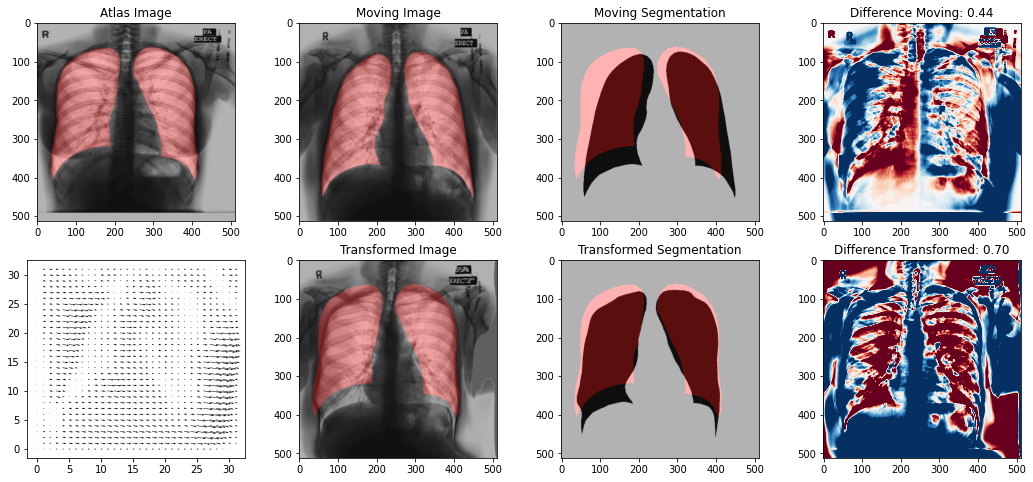

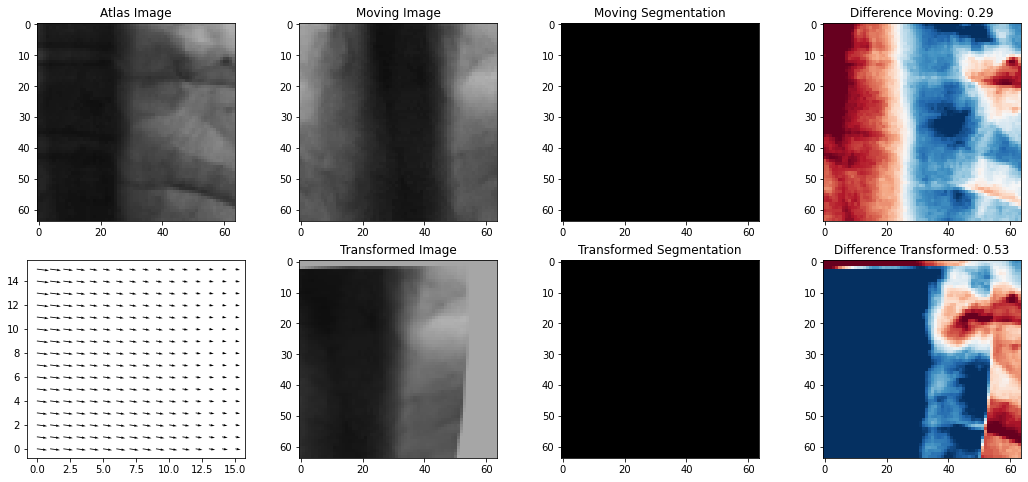

In [40]:
show_examples(3)